<a href="https://colab.research.google.com/github/rajy4683/S6EVA4/blob/master/S6_EVA4_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Final Accuracy: 99.44**
###  Number of parameters - 7288
### Number of epochs with 99.4 acc = 6

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/EVA4/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from MNISTRekog.basemodelclass import MNISTDigitBuilder

In [0]:
from MNISTRekog.utils.fileutils import *

In [4]:
print(rand_run_name())
print(generate_model_save_path())

13583a2135
/content/drive/My Drive/EVA4/model-177ab665df.h5


In [5]:
!pip install pytorch-ignite
!pip install torchsummary
!pip install wandb

In [6]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.utils.data import DataLoader
from ignite.handlers import Checkpoint, DiskSaver


import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

from argparse import ArgumentParser
from tqdm import tqdm
import os
import random


In [0]:
import logging
logging.propagate = False 

logging.getLogger().setLevel(logging.ERROR)

In [9]:
import wandb
#wandb.init()
#!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
# WandB – Config is a variable that holds and saves hyperparameters and inputs
# hyperparameter_defaults = dict(
#     dropout = 0.1,
#     channels_one = 16,
#     channels_two = 32,
#     batch_size = 64,
#     test_batch_size=64,
#     lr = 0.018,
#     momentum = 0.9,
#     no_cuda = False,
#     seed = 1,
#     epochs = 20,
#     bias = False,
#     log_interval = 10
#     )

hyperparameter_defaults = dict(
    dropout = 0.1,#0.07114420042272313,
    channels_one = 16,
    channels_two = 32,
    batch_size = 64,
    test_batch_size=34,
    lr = 0.04, #0.030455453938066226, #0.018,# 0.017530428914306426,
    momentum = 0.95, #0.8424379743502641,
    no_cuda = False,
    seed = 1,
    epochs = 15,
    bias = False,
    log_interval = 11,
    sched_lr_gamma = 0.5,
    sched_lr_step= 1,
    start_lr = 5
    )



wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config


In [12]:
#from basemodelclass import Net
model = MNISTDigitBuilder(dropout=0.1).to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
         MaxPool2d-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             576
      BatchNorm2d-11            [-1, 8, 14, 14]              16
             ReLU-12            [-1, 8, 14, 14]               0
          Dropout-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1, 16,

In [0]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
train_losses = []
test_losses = []
train_acc = []
test_acc = []

from tqdm import tqdm
def train(args, model, device, train_loader, optimizer, epoch_number):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        train_accuracy += pred.eq(target.view_as(pred)).sum().item()

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    print('\nEpoch: {:.0f} Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, train_loss, train_accuracy, len(train_loader.dataset),
        100. * train_accuracy / len(train_loader.dataset)))
    train_accuracy = (100. * train_accuracy) / len(train_loader.dataset)
    train_acc.append(train_accuracy)
    train_losses.append(train_loss)

    return train_accuracy, train_loss

def test(args, model, device, test_loader,classes,epoch_number):
    model.eval()
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
        #example_images.append(wandb.Image(
        #        data[0], caption="Pred: {} Truth: {}".format(classes[pred[0].item()], classes[target[0]])))

    test_loss /= len(test_loader.dataset)
    test_accuracy = (100. * correct) / len(test_loader.dataset)

    print('\nEpoch: {:.0f} Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        epoch_number, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(test_accuracy)
    test_losses.append(test_loss)

    return test_accuracy, test_loss

In [15]:
kwargs_2 = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
train_loader_2 = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms),
    batch_size=config.batch_size, shuffle=True, **kwargs_2)
len(train_loader_2)

938

In [0]:
api = wandb.Api()
my_runs = api.run("rajy4683/news4eva4/runs/ige4ebxr")
for file in my_runs.files():
    file.download(replace=True)
my_runs = api.runs("rajy4683/news4eva4",order='-created_at')


'zxhpkijn'

In [0]:
my_run_name = rand_run_name()
print(my_run_name)
print(generate_model_save_path(rand_string=my_run_name))

38b108dad4
/content/drive/My Drive/EVA4/model-38b108dad4.h5


In [0]:
from MNISTRekog.utils.fileutils import *

In [16]:
#model = MNISTDigitBuilder(start_channels=16,exponetate_layers=False).to(device)
#wandb.init(project="news4eva4")
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR
import os
hyperparameter_defaults = dict(
    run_name = rand_run_name(),
    dropout = 0.1,#0.07114420042272313,
    batch_size = 82,
    test_batch_size=34,
    lr = 0.032877745711371975, #0.007, #0.030455453938066226, #0.018,# 0.017530428914306426,
    momentum = 0.824176605049245, #0.95, #0.8424379743502641,
    no_cuda = False,
    seed = 1,
    epochs = 40,
    bias = False,
    sched_lr_gamma = 0.271611419527123, #0.99,
    sched_lr_step= 8,
    start_lr = 21,
    weight_decay=1.8540436495464775e-06
    )

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
train_losses = []
test_losses = []
train_acc = []
test_acc = []

wandb.init(config=hyperparameter_defaults, project="news4eva4")
wandb.watch_called = False # Re-run the model without restarting the runtime, unnecessary after our next release
config = wandb.config
model_path = generate_model_save_path(rand_string=config.run_name)
print("Model will be saved to:", model_path)


def main():
    use_cuda = not config.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    
    # Set random seeds and deterministic pytorch for reproducibility
    # random.seed(config.seed)       # python random seed
    torch.manual_seed(config.seed) # pytorch random seed
    # numpy.random.seed(config.seed) # numpy random seed
    torch.backends.cudnn.deterministic = True

    # Load the dataset: We're training our CNN on CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)
    # First we define the tranformations to apply to our images
    #kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                        transform=train_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=test_transforms),
        batch_size=config.batch_size, shuffle=True, **kwargs)

    # Initialize our model, recursively go over all modules and convert their parameters and buffers to CUDA tensors (if device is set to cuda)
    model = MNISTDigitBuilder(dropout=config.dropout).to(device)
    optimizer = optim.SGD(model.parameters(), lr=config.lr,
                          momentum=config.momentum, weight_decay=config.weight_decay)
    
    scheduler = StepLR(optimizer, step_size=config.sched_lr_step, gamma=config.sched_lr_gamma)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config.lr, steps_per_epoch=len(train_loader), epochs=config.epochs)
    #scheduler = MultiStepLR(optimizer, milestones=[10,20], gamma=config.sched_lr_gamma)
    # WandB – wandb.watch() automatically fetches all layer dimensions, gradients, model parameters and logs them automatically to your dashboard.
    # Using log="all" log histograms of parameter values in addition to gradients
    wandb.watch(model, log="all")

    for epoch in range(1, config.epochs + 1):
        epoch_train_acc,epoch_train_loss = train(config, model, device, train_loader, optimizer, epoch)        
        epoch_test_acc,epoch_test_loss = test(config, model, device, test_loader, classes,epoch)
        wandb.log({ "Train Accuracy": epoch_train_acc, 
                   "Train Loss": epoch_train_loss, 
                   "Test Accuracy":epoch_test_acc, 
                   "Test Loss": epoch_test_loss,
                   #"Learning Rate": config.lr})
                   "Learning Rate": scheduler.get_lr()})
        if (epoch > config.start_lr):
            scheduler.step()
        
    # WandB – Save the model checkpoint. This automatically saves a file to the cloud and associates it with the current run.

    torch.save(model.state_dict(), model_path)
    wandb.save('model.h5')

if __name__ == '__main__':
    main()

  0%|          | 0/732 [00:00<?, ?it/s]

Model will be saved to: /content/drive/My Drive/EVA4/model-28f815bd29.h5


loss=0.2731468081474304 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.07it/s]


Epoch: 1 Train set: Average loss: 0.0032, Accuracy: 55172/60000 (91.953%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 1 Test set: Average loss: 0.0649, Accuracy: 9793/10000 (97.930%)



loss=0.021075807511806488 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.42it/s]


Epoch: 2 Train set: Average loss: 0.0014, Accuracy: 57992/60000 (96.653%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 2 Test set: Average loss: 0.0459, Accuracy: 9854/10000 (98.540%)



loss=0.013249487616121769 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.42it/s]


Epoch: 3 Train set: Average loss: 0.0011, Accuracy: 58360/60000 (97.267%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 3 Test set: Average loss: 0.0377, Accuracy: 9873/10000 (98.730%)



loss=0.05605582147836685 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.43it/s]


Epoch: 4 Train set: Average loss: 0.0009, Accuracy: 58581/60000 (97.635%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 4 Test set: Average loss: 0.0293, Accuracy: 9896/10000 (98.960%)



loss=0.05461599677801132 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.35it/s]



Epoch: 5 Train set: Average loss: 0.0009, Accuracy: 58707/60000 (97.845%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 5 Test set: Average loss: 0.0329, Accuracy: 9896/10000 (98.960%)



loss=0.08943052589893341 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.55it/s]


Epoch: 6 Train set: Average loss: 0.0008, Accuracy: 58762/60000 (97.937%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 6 Test set: Average loss: 0.0336, Accuracy: 9899/10000 (98.990%)



loss=0.008048411458730698 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.13it/s]


Epoch: 7 Train set: Average loss: 0.0008, Accuracy: 58815/60000 (98.025%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 7 Test set: Average loss: 0.0263, Accuracy: 9912/10000 (99.120%)



loss=0.005823069717735052 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.21it/s]



Epoch: 8 Train set: Average loss: 0.0007, Accuracy: 58909/60000 (98.182%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 8 Test set: Average loss: 0.0285, Accuracy: 9909/10000 (99.090%)



loss=0.01062232069671154 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.27it/s]


Epoch: 9 Train set: Average loss: 0.0007, Accuracy: 58943/60000 (98.238%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 9 Test set: Average loss: 0.0253, Accuracy: 9927/10000 (99.270%)



loss=0.032582011073827744 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 39.12it/s]


Epoch: 10 Train set: Average loss: 0.0007, Accuracy: 58927/60000 (98.212%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 10 Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.080%)



loss=0.03420963138341904 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 39.37it/s]


Epoch: 11 Train set: Average loss: 0.0007, Accuracy: 58968/60000 (98.280%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 11 Test set: Average loss: 0.0246, Accuracy: 9919/10000 (99.190%)



loss=0.04372231662273407 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.34it/s]


Epoch: 12 Train set: Average loss: 0.0007, Accuracy: 58979/60000 (98.298%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 12 Test set: Average loss: 0.0268, Accuracy: 9902/10000 (99.020%)



loss=0.11932265013456345 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 40.25it/s]


Epoch: 13 Train set: Average loss: 0.0006, Accuracy: 59026/60000 (98.377%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 13 Test set: Average loss: 0.0244, Accuracy: 9917/10000 (99.170%)



loss=0.005423701833933592 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.53it/s]


Epoch: 14 Train set: Average loss: 0.0007, Accuracy: 59033/60000 (98.388%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 14 Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.240%)



loss=0.046390607953071594 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 39.79it/s]


Epoch: 15 Train set: Average loss: 0.0006, Accuracy: 59104/60000 (98.507%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 15 Test set: Average loss: 0.0230, Accuracy: 9928/10000 (99.280%)



loss=0.041222162544727325 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.87it/s]


Epoch: 16 Train set: Average loss: 0.0006, Accuracy: 59081/60000 (98.468%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 16 Test set: Average loss: 0.0229, Accuracy: 9924/10000 (99.240%)



loss=0.03991685062646866 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.20it/s]


Epoch: 17 Train set: Average loss: 0.0006, Accuracy: 59092/60000 (98.487%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 17 Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.310%)



loss=0.06217672675848007 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.25it/s]


Epoch: 18 Train set: Average loss: 0.0006, Accuracy: 59103/60000 (98.505%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 18 Test set: Average loss: 0.0224, Accuracy: 9923/10000 (99.230%)



loss=0.026295514777302742 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.05it/s]


Epoch: 19 Train set: Average loss: 0.0006, Accuracy: 59162/60000 (98.603%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 19 Test set: Average loss: 0.0205, Accuracy: 9933/10000 (99.330%)



loss=0.0229920856654644 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.96it/s]


Epoch: 20 Train set: Average loss: 0.0006, Accuracy: 59114/60000 (98.523%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 20 Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.210%)



loss=0.0346587598323822 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.99it/s]


Epoch: 21 Train set: Average loss: 0.0006, Accuracy: 59113/60000 (98.522%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 21 Test set: Average loss: 0.0209, Accuracy: 9940/10000 (99.400%)



loss=0.3279968202114105 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.93it/s]


Epoch: 22 Train set: Average loss: 0.0006, Accuracy: 59147/60000 (98.578%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 22 Test set: Average loss: 0.0204, Accuracy: 9936/10000 (99.360%)



loss=0.005318057723343372 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.11it/s]


Epoch: 23 Train set: Average loss: 0.0006, Accuracy: 59123/60000 (98.538%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 23 Test set: Average loss: 0.0248, Accuracy: 9927/10000 (99.270%)



loss=0.02003633603453636 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.82it/s]


Epoch: 24 Train set: Average loss: 0.0006, Accuracy: 59109/60000 (98.515%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 24 Test set: Average loss: 0.0200, Accuracy: 9943/10000 (99.430%)



loss=0.05443877354264259 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 39.18it/s]


Epoch: 25 Train set: Average loss: 0.0005, Accuracy: 59217/60000 (98.695%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 25 Test set: Average loss: 0.0209, Accuracy: 9936/10000 (99.360%)



loss=0.13358750939369202 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 38.92it/s]


Epoch: 26 Train set: Average loss: 0.0005, Accuracy: 59219/60000 (98.698%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 26 Test set: Average loss: 0.0195, Accuracy: 9937/10000 (99.370%)



loss=0.056046534329652786 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.16it/s]


Epoch: 27 Train set: Average loss: 0.0005, Accuracy: 59199/60000 (98.665%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 27 Test set: Average loss: 0.0216, Accuracy: 9935/10000 (99.350%)



loss=0.11795417219400406 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 40.01it/s]


Epoch: 28 Train set: Average loss: 0.0005, Accuracy: 59201/60000 (98.668%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 28 Test set: Average loss: 0.0197, Accuracy: 9931/10000 (99.310%)



loss=0.005440440494567156 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 40.73it/s]



Epoch: 29 Train set: Average loss: 0.0005, Accuracy: 59223/60000 (98.705%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 29 Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.250%)



loss=0.08130382001399994 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.94it/s]



Epoch: 30 Train set: Average loss: 0.0005, Accuracy: 59253/60000 (98.755%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 30 Test set: Average loss: 0.0179, Accuracy: 9939/10000 (99.390%)



loss=0.05107956752181053 batch_id=731: 100%|██████████| 732/732 [00:20<00:00, 34.88it/s]



Epoch: 31 Train set: Average loss: 0.0004, Accuracy: 59377/60000 (98.962%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 31 Test set: Average loss: 0.0171, Accuracy: 9944/10000 (99.440%)



loss=0.012327786535024643 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.93it/s]


Epoch: 32 Train set: Average loss: 0.0004, Accuracy: 59352/60000 (98.920%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 32 Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.440%)



loss=0.00426053162664175 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 39.43it/s]


Epoch: 33 Train set: Average loss: 0.0004, Accuracy: 59301/60000 (98.835%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 33 Test set: Average loss: 0.0174, Accuracy: 9948/10000 (99.480%)



loss=0.019780093804001808 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 33.81it/s]



Epoch: 34 Train set: Average loss: 0.0004, Accuracy: 59342/60000 (98.903%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 34 Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.460%)



loss=0.0650181770324707 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.44it/s]



Epoch: 35 Train set: Average loss: 0.0004, Accuracy: 59297/60000 (98.828%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 35 Test set: Average loss: 0.0182, Accuracy: 9935/10000 (99.350%)



loss=0.0037286116275936365 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.11it/s]



Epoch: 36 Train set: Average loss: 0.0004, Accuracy: 59349/60000 (98.915%)



  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 36 Test set: Average loss: 0.0173, Accuracy: 9944/10000 (99.440%)



loss=0.05033734068274498 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 38.97it/s]


Epoch: 37 Train set: Average loss: 0.0004, Accuracy: 59345/60000 (98.908%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 37 Test set: Average loss: 0.0175, Accuracy: 9940/10000 (99.400%)



loss=0.02340671978890896 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.12it/s]


Epoch: 38 Train set: Average loss: 0.0004, Accuracy: 59344/60000 (98.907%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 38 Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.420%)



loss=0.020428234711289406 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.64it/s]


Epoch: 39 Train set: Average loss: 0.0004, Accuracy: 59326/60000 (98.877%)




  0%|          | 0/732 [00:00<?, ?it/s]


Epoch: 39 Test set: Average loss: 0.0167, Accuracy: 9948/10000 (99.480%)



loss=0.08958061784505844 batch_id=731: 100%|██████████| 732/732 [00:21<00:00, 34.23it/s]



Epoch: 40 Train set: Average loss: 0.0004, Accuracy: 59363/60000 (98.938%)


Epoch: 40 Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.450%)



In [0]:
import wandb
api = wandb.Api()

# run is specified by <entity>/<project>/<run id>
run = api.run("rajy4683/news4eva4/m5lfrvxr")

# save the metrics for the run to a csv file
metrics_dataframe = run.history()
metrics_dataframe.to_csv("metrics.csv")

In [37]:
metrics_dataframe['Learning Rate']

0                     [0.007]
1                     [0.007]
2                     [0.007]
3                     [0.007]
4                     [0.007]
5                     [0.007]
6                     [0.007]
7                     [0.007]
8                     [0.007]
9                     [0.007]
10                    [0.007]
11                    [0.007]
12                    [0.007]
13                    [0.007]
14                    [0.007]
15                    [0.007]
16                    [0.007]
17                    [0.007]
18                    [0.007]
19                    [0.007]
20                    [0.007]
21                [0.0068607]
22              [0.006792093]
23            [0.00672417207]
24    [0.0066569303493000005]
25     [0.006590361045807001]
26    [0.0065244574353489305]
27     [0.006459212860995441]
28     [0.006394620732385487]
29     [0.006330674525061632]
30    [0.0062673677798110155]
31     [0.006204694102012905]
32     [0.006142647160992776]
33     [0.

In [0]:
metrics_dataframe['Learning Rate2']=[    metrics_dataframe['Learning Rate'][counter][0] for counter in range(len(metrics_dataframe['Learning Rate'])) ]

In [33]:
metrics_dataframe['Learning Rate2']

0     0.007000
1     0.007000
2     0.007000
3     0.007000
4     0.007000
5     0.007000
6     0.007000
7     0.007000
8     0.007000
9     0.007000
10    0.007000
11    0.007000
12    0.007000
13    0.007000
14    0.007000
15    0.007000
16    0.007000
17    0.007000
18    0.007000
19    0.007000
20    0.007000
21    0.006861
22    0.006792
23    0.006724
24    0.006657
25    0.006590
26    0.006524
27    0.006459
28    0.006395
29    0.006331
30    0.006267
31    0.006205
32    0.006143
33    0.006081
34    0.006020
35    0.005960
36    0.005901
37    0.005842
38    0.005783
39    0.005725
Name: Learning Rate2, dtype: float64

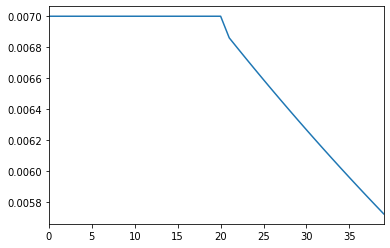

In [35]:
metrics_dataframe['Learning Rate2'].plot()
#, 'Test Accuracy']].plot()

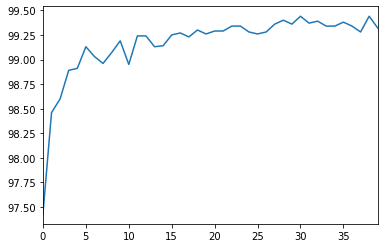

In [36]:
metrics_dataframe['Test Accuracy'].plot()

In [19]:
model.conv1.parameters()

<generator object Module.parameters at 0x7fa3c8ad08e0>

In [0]:
torch.save(model.state_dict(), "/content/drive/My Drive/EVA4/model_7288.h5")


Text(0.5, 1.0, 'Test Accuracy')

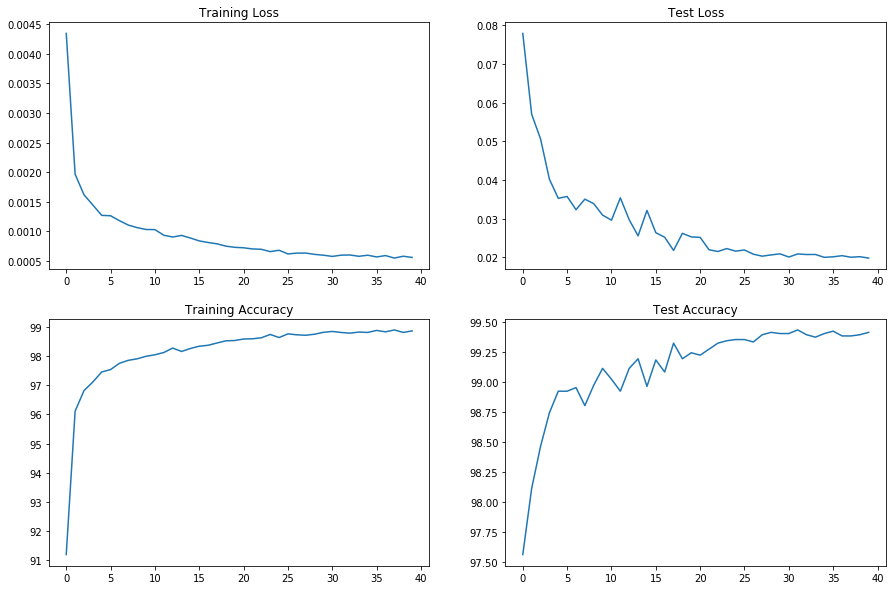

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")